<a href="https://colab.research.google.com/github/JasmineHuang25/Rock_Scissors_Paper_Gmae/blob/main/Final_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rock-Scissors-Paper Game Using Convolutional Neural Network

## Table of Contents 

#### [Mount Google Drive](#1)
#### [Install and Import](#2)
#### [Prepare Data](#3)
#### [Models](#4)
- [Baseline Model](#4.1)
- [Best Model](#4.2)
- [Save the Best Model](#4.3)

#### [Web App Deployment Using Gradio](#5)

## Mount Google drive <a class="anchor" id="1"></a>

To obtain dataset

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Install and Import <a class="anchor" id="2"></a>

In [ ]:
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l1, l2

import os
import cv2
from keras.preprocessing import image
from keras import utils

from sklearn.metrics import confusion_matrix, classification_report

## Prepare Data <a class="anchor" id="3"></a>

### Creat directory for dataset

In [ ]:
train_dir = '/content/gdrive/MyDrive/rock_paper_scissors/MVP/Dataset0204/train'
test_dir = '/content/gdrive/MyDrive/rock_paper_scissors/MVP/Dataset0204/test'


### Test ImageDataGenerator

In [ ]:
# No invert_color!!

sample_generator = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    height_shift_range=0.2,
    width_shift_range=0.2,
    fill_mode='nearest',
    zoom_range=0.6,
    preprocessing_function=None
)

sample_images = sample_generator.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    color_mode="rgb",
    class_mode=None,
    batch_size=1,
    shuffle=True,    
    seed=42
)

Found 13500 images belonging to 3 classes.


In [ ]:
# sample_images[0].shape

(1, 150, 150, 3)

In [ ]:
# img_res = sample_images[0].reshape(150, 150, 1)
# img_res.shape

(150, 150, 1)

In [ ]:
from PIL import Image, ImageChops

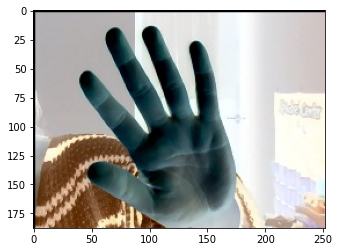

In [ ]:
# Invert image (Image type)

# Opening the test image, and saving it's object
path = '/content/gdrive/MyDrive/rock_paper_scissors/MVP/Dataset0204/train/paper/1.jpg'

img = Image.open(path)
 
# Passing the image object to invert() 
inv_img = ImageChops.invert(img)
 
# Displaying the output image
plt.imshow(inv_img)

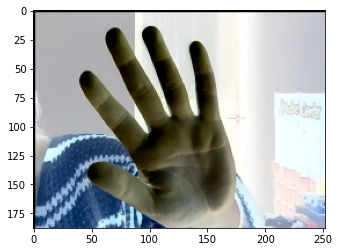

In [ ]:
# # Inver image (Array)

path = '/content/gdrive/MyDrive/rock_paper_scissors/MVP/Dataset0204/train/paper/1.jpg'
image_src = cv2.imread(path)
image_i = cv2.bitwise_not(image_src)
plt.imshow(image_i)

Found 13500 images belonging to 3 classes.


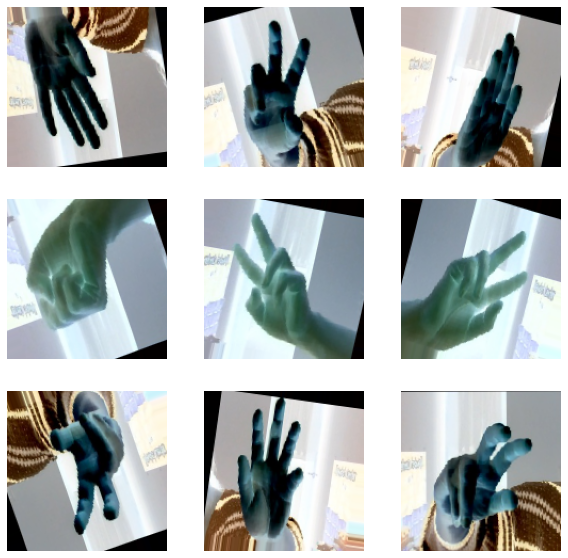

In [ ]:
# Add preprocessing_function

# Define invert
def InvertImg(imagem):
    imagem = (255-imagem)
    return imagem

inv_sample_generator = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    height_shift_range=0,
    width_shift_range=0,
    fill_mode='nearest',
    zoom_range=0.1,
    shear_range=0.2,
    preprocessing_function=InvertImg
)

inv_sample_images = inv_sample_generator.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    color_mode="rgb",
    class_mode=None,
    batch_size=1,
    shuffle=True,    
    seed=42
)

plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = inv_sample_images.next()[0]
    plt.imshow(img)
    plt.axis('off')

plt.show()

### Use ImageDataGenerator for processing images and create more images

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0,
                                  height_shift_range=0,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  preprocessing_function=InvertImg)

test_datagen = ImageDataGenerator(rescale=1./255,
                                  preprocessing_function=InvertImg)

In [ ]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=126,
                                                    target_size=(150,150),
                                                    class_mode="categorical",
                                                    shuffle=True)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=126,
                                                  target_size=(150,150),
                                                  class_mode="categorical",
                                                  shuffle=True)



Found 13500 images belonging to 3 classes.
Found 4350 images belonging to 3 classes.


In [ ]:
# STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

### Visulizations for accuracy and loss function

In [ ]:
def acc_loss_plt(model_history):
  acc = model_history.history["accuracy"]
  val_acc = model_history.history["val_accuracy"]
  loss = model_history.history["loss"]
  val_loss = model_history.history["val_loss"]
  
  epoch = range(len(acc))
  
  plt.plot(epoch, acc, "r", label = "Training Accuracy")
  plt.plot(epoch, val_acc, "b", label = "Validation Accuracy")
  plt.title("Training And Validation Accuracy")
  plt.legend()
  plt.figure()
  
  plt.plot(epoch, loss, "r", label = "Training Loss")
  plt.plot(epoch, val_loss, "b", label = "Validation Loss")
  plt.title("Training And Validation Loss")
  plt.legend()
  return plt.show()

## Models<a class="anchor" id="4"></a>

## Baseline Model<a class="anchor" id="4.1"></a>

In [ ]:
basic_model = keras.Sequential([
    keras.layers.Conv2D(128, (3,3), activation="relu", input_shape=(150,150,3)),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), activation="relu"),
    keras.layers.MaxPooling2D(2,2),
      
    keras.layers.Conv2D(256, (3,3), activation="relu"),   
    keras.layers.MaxPooling2D(2,2),    

    keras.layers.Conv2D(256, (3,3), activation="relu"),  
    keras.layers.MaxPooling2D(2,2),
       
    keras.layers.Flatten(),
    keras.layers.Dropout(0.8),
    keras.layers.Dense(512, activation="relu", activity_regularizer=l2(l=0.001)),
    keras.layers.Dense(3, activation="softmax")
])

basic_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 256)      0

In [ ]:
basic_model.compile(optimizer='adam',
                    loss="categorical_crossentropy",
                    metrics=['accuracy'])

In [ ]:
# Set up callback layer after adding upto 40K images:
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
basic_histry = basic_model.fit(train_generator,
                               validation_data=test_generator,
                               validation_steps=3,
                               epochs=30,
                               steps_per_epoch=20)

Epoch 1/30
20/20 [==============================] - 2116s 106s/step - loss: 1.1347 - accuracy: 0.3968 - val_loss: 1.0386 - val_accuracy: 0.3783
Epoch 2/30
20/20 [==============================] - 1711s 86s/step - loss: 0.9350 - accuracy: 0.5341 - val_loss: 0.7978 - val_accuracy: 0.5926
Epoch 3/30
20/20 [==============================] - 1376s 70s/step - loss: 0.6743 - accuracy: 0.6837 - val_loss: 0.9556 - val_accuracy: 0.5820
Epoch 4/30
20/20 [==============================] - 1086s 55s/step - loss: 0.5305 - accuracy: 0.7988 - val_loss: 0.9364 - val_accuracy: 0.6085
Epoch 5/30
20/20 [==============================] - 962s 49s/step - loss: 0.4559 - accuracy: 0.8310 - val_loss: 0.8139 - val_accuracy: 0.6534
Epoch 6/30
20/20 [==============================] - 753s 38s/step - loss: 0.3436 - accuracy: 0.8821 - val_loss: 1.0041 - val_accuracy: 0.6587
Epoch 7/30
20/20 [==============================] - 599s 30s/step - loss: 0.3013 - accuracy: 0.9040 - val_loss: 0.6090 - val_accuracy: 0.8122
E

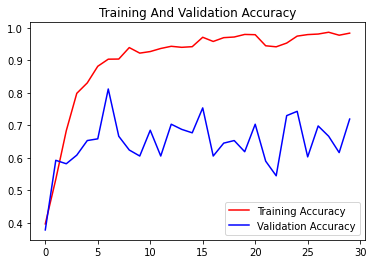

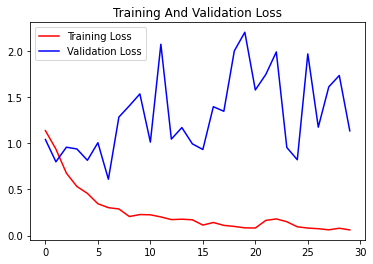

In [ ]:
acc_loss_plt(basic_histry)

### Finding:

Training well but model can't recognize new data well. Try to increase Dropout rate.

## Convolutional Model 1

In [ ]:
con_model1 = keras.Sequential([
    keras.layers.Conv2D(128, (3,3), activation="relu", input_shape=(150,150,3), kernel_regularizer=l2(l=0.0001)),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), activation="relu"),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(256, (3,3), activation="relu"),   
    keras.layers.MaxPooling2D(2,2),    

    keras.layers.Conv2D(512, (3,3), activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D(2,2),
       
    keras.layers.Flatten(),
    keras.layers.Dropout(0.8),
    keras.layers.Dense(512, activation="relu", activity_regularizer=l2(l=0.0001)),
    keras.layers.Dense(3, activation="softmax")
])

con_model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 128)     3584      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 128)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 128)       147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 256)       295168    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 256)     

In [ ]:
con_model1.compile(optimizer='adam',
                   loss="categorical_crossentropy",
                    metrics=['accuracy'])

In [ ]:
con_model1_histry = con_model1.fit(train_generator,
                           validation_data=test_generator,
                           validation_steps=3,
                           epochs=30,
                           steps_per_epoch=20,
                           verbose=1)

Epoch 1/30
20/20 [==============================] - 27s 1s/step - loss: 1.1599 - accuracy: 0.3397 - val_loss: 1.0962 - val_accuracy: 0.3254
Epoch 2/30
20/20 [==============================] - 25s 1s/step - loss: 1.0144 - accuracy: 0.4639 - val_loss: 0.8911 - val_accuracy: 0.4921
Epoch 3/30
20/20 [==============================] - 27s 1s/step - loss: 0.8422 - accuracy: 0.5988 - val_loss: 1.3036 - val_accuracy: 0.4444
Epoch 4/30
20/20 [==============================] - 23s 1s/step - loss: 0.7135 - accuracy: 0.6932 - val_loss: 0.8180 - val_accuracy: 0.5926
Epoch 5/30
20/20 [==============================] - 20s 1s/step - loss: 0.5633 - accuracy: 0.7722 - val_loss: 1.0281 - val_accuracy: 0.4762
Epoch 6/30
20/20 [==============================] - 24s 1s/step - loss: 0.4601 - accuracy: 0.8190 - val_loss: 0.9042 - val_accuracy: 0.5873
Epoch 7/30
20/20 [==============================] - 23s 1s/step - loss: 0.3672 - accuracy: 0.8540 - val_loss: 1.2790 - val_accuracy: 0.6402
Epoch 8/30
20/20 [==

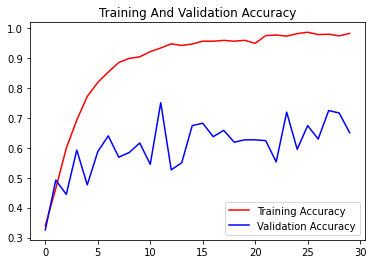

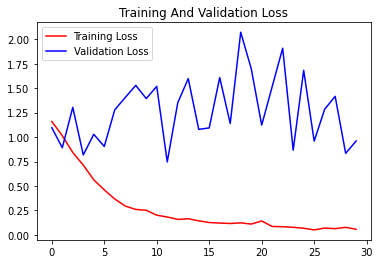

In [ ]:
acc_loss_plt(con_model1_histry)

### Finding:

Still overfit. Add more Dropout layer.

## Convolutional Model 2

In [ ]:
con_model2 = keras.Sequential([
    keras.layers.Conv2D(64, (3,3), activation="relu", input_shape=(150,150,3), kernel_regularizer=l2(l=0.0001)),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001)),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(256, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001)),   
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D(2,2),    

    keras.layers.Conv2D(256, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D(2,2),
       
    keras.layers.Flatten(),
    keras.layers.Dropout(0.8),
    keras.layers.Dense(512, activation="relu", activity_regularizer=l2(l=0.0001)),
    keras.layers.Dense(3, activation="softmax")
])

con_model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 72, 72, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 128)      0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 34, 34, 256)       295168    
                                                                 
 dropout_3 (Dropout)         (None, 34, 34, 256)      

In [ ]:
con_model2.compile(optimizer="adam",
                   loss="categorical_crossentropy",
                   metrics=["accuracy"])

In [ ]:
con_model2_history = con_model2.fit(train_generator,
                                    validation_data=test_generator,
                                    validation_steps=3,
                                    epochs=30,
                                    steps_per_epoch=30,
                                    verbose=1)

Epoch 1/30
30/30 [==============================] - 27s 811ms/step - loss: 1.1756 - accuracy: 0.3989 - val_loss: 0.9610 - val_accuracy: 0.5582
Epoch 2/30
30/30 [==============================] - 24s 798ms/step - loss: 0.8949 - accuracy: 0.6035 - val_loss: 0.7614 - val_accuracy: 0.6614
Epoch 3/30
30/30 [==============================] - 25s 815ms/step - loss: 0.6276 - accuracy: 0.7524 - val_loss: 0.8089 - val_accuracy: 0.6958
Epoch 4/30
30/30 [==============================] - 24s 793ms/step - loss: 0.4441 - accuracy: 0.8407 - val_loss: 0.7723 - val_accuracy: 0.7143
Epoch 5/30
30/30 [==============================] - 25s 831ms/step - loss: 0.3516 - accuracy: 0.8794 - val_loss: 0.8232 - val_accuracy: 0.6720
Epoch 6/30
30/30 [==============================] - 24s 838ms/step - loss: 0.2869 - accuracy: 0.9031 - val_loss: 1.1953 - val_accuracy: 0.5979
Epoch 7/30
30/30 [==============================] - 25s 837ms/step - loss: 0.2534 - accuracy: 0.9146 - val_loss: 1.2360 - val_accuracy: 0.5979

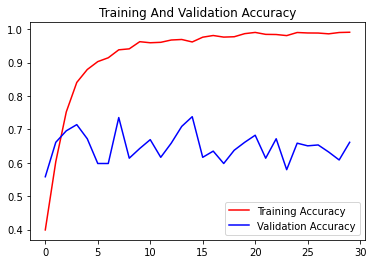

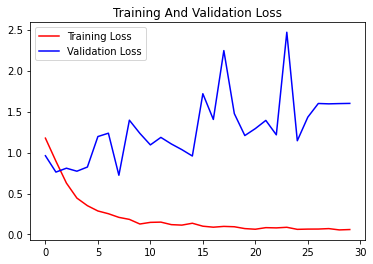

In [ ]:
acc_loss_plt(con_model2_history)

### Finding:
Let's try to add more layers.


## Convolutional Model 3

In [ ]:
con_model3 = keras.Sequential([
    keras.layers.Conv2D(64, (3,3), activation="relu", input_shape=(150,150,3), kernel_regularizer=l2(l=0.001)),
    keras.layers.Conv2D(64, (3,3), activation="relu"),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), activation="relu"),
    keras.layers.Conv2D(256, (3,3), activation="relu",  kernel_regularizer=l2(l=0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D(2,2),
       
    keras.layers.Flatten(),
    keras.layers.Dropout(0.8),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(512, activation="relu", activity_regularizer=l2(l=0.001)),
    keras.layers.Dense(3, activation="softmax")
])

con_model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 conv2d_19 (Conv2D)          (None, 146, 146, 64)      36928     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 73, 73, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 71, 71, 128)       73856     
                                                                 
 conv2d_21 (Conv2D)          (None, 69, 69, 256)       295168    
                                                                 
 dropout_9 (Dropout)         (None, 69, 69, 256)       0         
                                                      

In [ ]:
con_model3.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

con_model3_history = con_model3.fit(train_generator,
                                    validation_data=test_generator,
                                    validation_steps=3,
                                    epochs=35,
                                    steps_per_epoch=30,
                                    verbose=1)

Epoch 1/35
30/30 [==============================] - 33s 853ms/step - loss: 1.6176 - accuracy: 0.5128 - val_loss: 2.5810 - val_accuracy: 0.3069
Epoch 2/35
30/30 [==============================] - 25s 833ms/step - loss: 0.8332 - accuracy: 0.7550 - val_loss: 1.4674 - val_accuracy: 0.3439
Epoch 3/35
30/30 [==============================] - 25s 834ms/step - loss: 0.6875 - accuracy: 0.8360 - val_loss: 1.2116 - val_accuracy: 0.3783
Epoch 4/35
30/30 [==============================] - 25s 831ms/step - loss: 0.6289 - accuracy: 0.8619 - val_loss: 1.1663 - val_accuracy: 0.5185
Epoch 5/35
30/30 [==============================] - 26s 838ms/step - loss: 0.5795 - accuracy: 0.8907 - val_loss: 1.0133 - val_accuracy: 0.5238
Epoch 6/35
30/30 [==============================] - 25s 827ms/step - loss: 0.5652 - accuracy: 0.8870 - val_loss: 1.0271 - val_accuracy: 0.4762
Epoch 7/35
30/30 [==============================] - 25s 819ms/step - loss: 0.5238 - accuracy: 0.8949 - val_loss: 1.2880 - val_accuracy: 0.3148

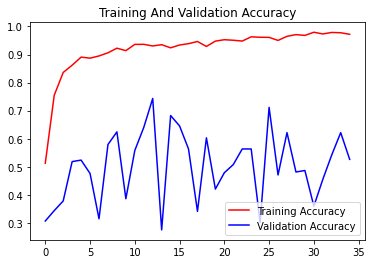

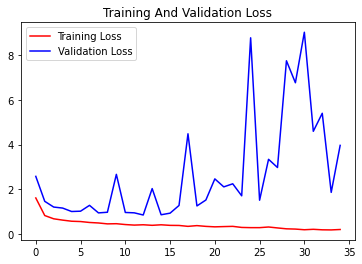

In [ ]:
acc_loss_plt(con_model3_history)

### Finding:
It's getting worse.  Try to add more layers!

## Convolutional Model 4

In [ ]:
con_model4 = keras.Sequential([
    keras.layers.Conv2D(64, (3,3), activation="relu", input_shape=(150,150,3), kernel_regularizer=l2(l=0.0001)),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D(2,2),
      
    keras.layers.Conv2D(128, (3,3), activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D(2,2),
      
    keras.layers.Conv2D(256, (3,3), activation="relu"),
    keras.layers.Dropout(0.2),   
    keras.layers.MaxPooling2D(2,2),    

    keras.layers.Conv2D(512, (3,3), activation="relu"),
    keras.layers.Dropout(0.2),  
    keras.layers.MaxPooling2D(2,2),
       
    keras.layers.Flatten(),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(512, activation="relu", activity_regularizer=l2(l=0.001), kernel_regularizer=l2(l=0.001)),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(256, activation="relu", activity_regularizer=l2(l=0.001), kernel_regularizer=l2(l=0.001)),
    keras.layers.Dense(3, activation="softmax")
])

con_model4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 72, 72, 128)       73856     
                                                                 
 dropout_11 (Dropout)        (None, 72, 72, 128)       0         
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 36, 36, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 34, 34, 128)      

In [ ]:
con_model4.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

con_model4_history = con_model4.fit(train_generator,
                                    validation_data=test_generator,
                                    validation_steps=3,
                                    epochs=35,
                                    steps_per_epoch=20,
                                    verbose=1)

Epoch 1/35
20/20 [==============================] - 18s 797ms/step - loss: 2.5862 - accuracy: 0.3433 - val_loss: 1.8260 - val_accuracy: 0.3148
Epoch 2/35
20/20 [==============================] - 17s 851ms/step - loss: 1.7614 - accuracy: 0.3706 - val_loss: 1.6476 - val_accuracy: 0.3413
Epoch 3/35
20/20 [==============================] - 17s 843ms/step - loss: 1.5867 - accuracy: 0.3667 - val_loss: 1.5093 - val_accuracy: 0.4418
Epoch 4/35
20/20 [==============================] - 17s 843ms/step - loss: 1.5034 - accuracy: 0.4456 - val_loss: 1.4430 - val_accuracy: 0.3228
Epoch 5/35
20/20 [==============================] - 17s 828ms/step - loss: 1.3158 - accuracy: 0.4631 - val_loss: 1.2118 - val_accuracy: 0.5317
Epoch 6/35
20/20 [==============================] - 17s 820ms/step - loss: 1.1993 - accuracy: 0.5568 - val_loss: 1.0952 - val_accuracy: 0.6270
Epoch 7/35
20/20 [==============================] - 17s 843ms/step - loss: 0.9980 - accuracy: 0.6329 - val_loss: 1.0293 - val_accuracy: 0.5926

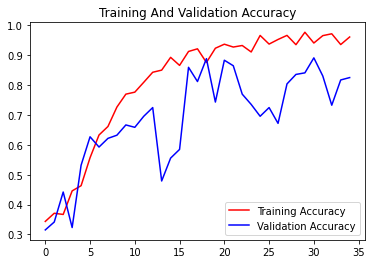

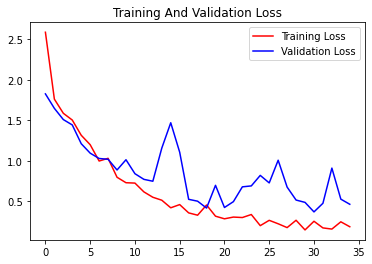

In [ ]:
acc_loss_plt(con_model4_history)

### Finding:
Adding more layers is the right direction. Adjust from revious model.



## Convolutional Model 5

In [ ]:
con_model5 = keras.Sequential([
    keras.layers.Conv2D(64, (3,3), activation="relu", input_shape=(150,150,3), kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D(2,2),
      
    keras.layers.Conv2D(128, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001)),
    keras.layers.Conv2D(128, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D(2,2),
      
    keras.layers.Conv2D(512, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.2),   
    keras.layers.MaxPooling2D(2,2),    

    keras.layers.Conv2D(512, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.2),  
    keras.layers.MaxPooling2D(2,2),
       
    keras.layers.Flatten(),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(512, activation="relu", activity_regularizer=l2(l=0.001), kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(256, activation="relu", activity_regularizer=l2(l=0.001), kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dense(3, activation="softmax")
])

con_model5.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 dropout_17 (Dropout)        (None, 148, 148, 64)      0         
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 72, 72, 128)       73856     
                                                                 
 dropout_18 (Dropout)        (None, 72, 72, 128)       0         
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 36, 36, 128)      0         
 g2D)                                                 

In [ ]:
con_model5.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

con_model5_history = con_model5.fit(train_generator,
                                    validation_data=test_generator,
                                    validation_steps=3,
                                    epochs=35,
                                    steps_per_epoch=20,
                                    verbose=1)

Epoch 1/35
20/20 [==============================] - 20s 845ms/step - loss: 1.8901 - accuracy: 0.3401 - val_loss: 1.2612 - val_accuracy: 0.3624
Epoch 2/35
20/20 [==============================] - 17s 842ms/step - loss: 1.2481 - accuracy: 0.3444 - val_loss: 1.2415 - val_accuracy: 0.3201
Epoch 3/35
20/20 [==============================] - 17s 858ms/step - loss: 1.2367 - accuracy: 0.3571 - val_loss: 1.2116 - val_accuracy: 0.3333
Epoch 4/35
20/20 [==============================] - 17s 847ms/step - loss: 1.1945 - accuracy: 0.3524 - val_loss: 1.1843 - val_accuracy: 0.3492
Epoch 5/35
20/20 [==============================] - 17s 844ms/step - loss: 1.1627 - accuracy: 0.3798 - val_loss: 1.0950 - val_accuracy: 0.5344
Epoch 6/35
20/20 [==============================] - 17s 849ms/step - loss: 1.1732 - accuracy: 0.4091 - val_loss: 1.1189 - val_accuracy: 0.4206
Epoch 7/35
20/20 [==============================] - 17s 849ms/step - loss: 1.1309 - accuracy: 0.4885 - val_loss: 1.0384 - val_accuracy: 0.5238

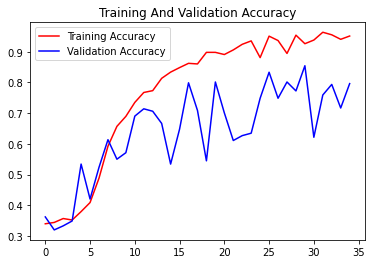

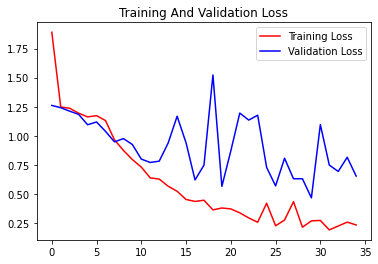

In [ ]:
acc_loss_plt(con_model5_history)

### Finding:
Not getting better.  Keep trying.

## Convolutional Model 6

In [ ]:
con_model6 = keras.Sequential([
    keras.layers.Conv2D(128, (3,3), activation="relu", input_shape=(150,150,3), kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D(2,2),
      
    keras.layers.Conv2D(256, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D(2,2),
      
    keras.layers.Conv2D(256, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.2),   
    keras.layers.MaxPooling2D(2,2),    

    keras.layers.Conv2D(512, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.2),  
    keras.layers.MaxPooling2D(2,2),
       
    keras.layers.Flatten(),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(512, activation="relu", activity_regularizer=l2(l=0.001), kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.8),
    keras.layers.Dense(256, activation="relu", activity_regularizer=l2(l=0.001), kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dense(3, activation="softmax")
])

con_model6.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 148, 148, 128)     3584      
                                                                 
 dropout_24 (Dropout)        (None, 148, 148, 128)     0         
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 74, 74, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 72, 72, 128)       147584    
                                                                 
 dropout_25 (Dropout)        (None, 72, 72, 128)       0         
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 36, 36, 128)      0         
 g2D)                                                 

In [ ]:
con_model6.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

con_model6_history = con_model6.fit(train_generator,
                                    validation_data=test_generator,
                                    validation_steps=3,
                                    epochs=40,
                                    steps_per_epoch=30,
                                    verbose=1)

Epoch 1/40
30/30 [==============================] - 27s 852ms/step - loss: 1.2922 - accuracy: 0.3434 - val_loss: 1.2585 - val_accuracy: 0.3757
Epoch 2/40
30/30 [==============================] - 25s 811ms/step - loss: 1.2341 - accuracy: 0.3704 - val_loss: 1.2382 - val_accuracy: 0.3571
Epoch 3/40
30/30 [==============================] - 25s 836ms/step - loss: 1.1692 - accuracy: 0.4302 - val_loss: 1.1316 - val_accuracy: 0.4735
Epoch 4/40
30/30 [==============================] - 25s 829ms/step - loss: 1.0779 - accuracy: 0.5183 - val_loss: 1.0062 - val_accuracy: 0.5476
Epoch 5/40
30/30 [==============================] - 25s 820ms/step - loss: 0.9153 - accuracy: 0.6354 - val_loss: 0.9175 - val_accuracy: 0.6799
Epoch 6/40
30/30 [==============================] - 25s 805ms/step - loss: 0.7378 - accuracy: 0.7454 - val_loss: 0.9361 - val_accuracy: 0.5370
Epoch 7/40
30/30 [==============================] - 25s 809ms/step - loss: 0.6203 - accuracy: 0.7992 - val_loss: 0.7260 - val_accuracy: 0.7381

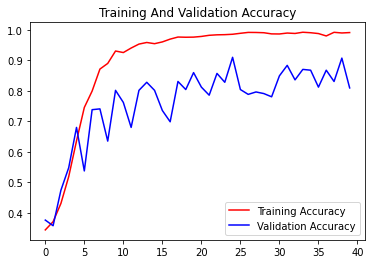

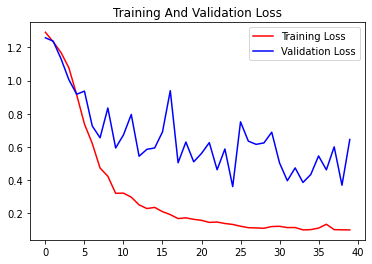

In [ ]:
acc_loss_plt(con_model6_history)

### Finding:
Getting a little bit better. Keep trying! 

## Convolutional Model 7

In [ ]:
con_model7 = keras.Sequential([
    keras.layers.Conv2D(128, (3,3), activation="relu", input_shape=(150,150,3), kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.3),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.3),
    keras.layers.MaxPooling2D(2,2),
      
    keras.layers.Conv2D(256, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.3),
    keras.layers.MaxPooling2D(2,2),
      
    keras.layers.Conv2D(256, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.3),   
    keras.layers.MaxPooling2D(2,2),    

    keras.layers.Conv2D(512, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.3),  
    keras.layers.MaxPooling2D(2,2),
       
    keras.layers.Flatten(),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(512, activation="relu", activity_regularizer=l2(l=0.001), kernel_regularizer=l2(l=0.001)),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(256, activation="relu", activity_regularizer=l2(l=0.001), kernel_regularizer=l2(l=0.001)),
    keras.layers.Dense(3, activation="softmax")
])

con_model7.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 148, 148, 128)     3584      
                                                                 
 dropout_38 (Dropout)        (None, 148, 148, 128)     0         
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 74, 74, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 72, 72, 128)       147584    
                                                                 
 dropout_39 (Dropout)        (None, 72, 72, 128)       0         
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 36, 36, 128)      0         
 g2D)                                                 

In [ ]:
con_model7.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

con_model7_history = con_model7.fit(train_generator,
                                    validation_data=test_generator,
                                    validation_steps=3,
                                    epochs=40,
                                    steps_per_epoch=30,
                                    verbose=1)

Epoch 1/40
30/30 [==============================] - 26s 840ms/step - loss: 2.1286 - accuracy: 0.3667 - val_loss: 1.8893 - val_accuracy: 0.4577
Epoch 2/40
30/30 [==============================] - 24s 797ms/step - loss: 1.7233 - accuracy: 0.4436 - val_loss: 1.5881 - val_accuracy: 0.4365
Epoch 3/40
30/30 [==============================] - 25s 815ms/step - loss: 1.3181 - accuracy: 0.6122 - val_loss: 1.3746 - val_accuracy: 0.5317
Epoch 4/40
30/30 [==============================] - 24s 805ms/step - loss: 1.0814 - accuracy: 0.7045 - val_loss: 1.1400 - val_accuracy: 0.6032
Epoch 5/40
30/30 [==============================] - 25s 820ms/step - loss: 0.8718 - accuracy: 0.7817 - val_loss: 1.2323 - val_accuracy: 0.4815
Epoch 6/40
30/30 [==============================] - 25s 829ms/step - loss: 0.6995 - accuracy: 0.8526 - val_loss: 1.1088 - val_accuracy: 0.5899
Epoch 7/40
30/30 [==============================] - 25s 806ms/step - loss: 0.6164 - accuracy: 0.8769 - val_loss: 0.9394 - val_accuracy: 0.6614

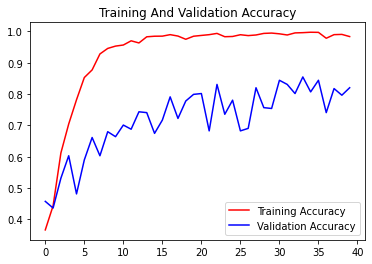

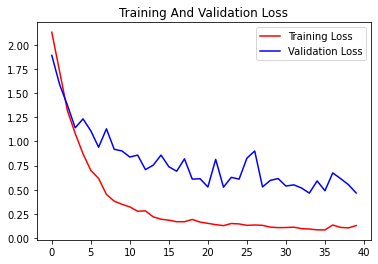

In [ ]:
acc_loss_plt(con_model7_history)

### Finding:
Not as good as the previous model.


## Convolutional Model 8

In [ ]:
con_model8 = keras.Sequential([
    keras.layers.Conv2D(128, (3,3), activation="relu", input_shape=(150,150,3), kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.3),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.3),
    keras.layers.MaxPooling2D(2,2),
      
    # keras.layers.Conv2D(256, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001)),
    # keras.layers.Dropout(0.2),
    # keras.layers.MaxPooling2D(2,2),
      
    keras.layers.Conv2D(256, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.3),   
    keras.layers.MaxPooling2D(2,2),    

    keras.layers.Conv2D(512, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.3),  
    keras.layers.MaxPooling2D(2,2),
       
    keras.layers.Flatten(),
    keras.layers.Dropout(0.8),
    keras.layers.Dense(512, activation="relu", activity_regularizer=l2(l=0.001), kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dense(3, activation="softmax")
])

con_model8.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 148, 148, 128)     3584      
                                                                 
 dropout_45 (Dropout)        (None, 148, 148, 128)     0         
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 74, 74, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 72, 72, 128)       147584    
                                                                 
 dropout_46 (Dropout)        (None, 72, 72, 128)       0         
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 36, 36, 128)      0         
 g2D)                                                

In [ ]:
con_model8.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

con_model8_history = con_model8.fit(train_generator,
                                    validation_data=test_generator,
                                    validation_steps=3,
                                    epochs=60,
                                    steps_per_epoch=10,
                                    verbose=1)

Epoch 1/60
10/10 [==============================] - 11s 978ms/step - loss: 2.1341 - accuracy: 0.3333 - val_loss: 1.2621 - val_accuracy: 0.3333
Epoch 2/60
10/10 [==============================] - 9s 903ms/step - loss: 1.2588 - accuracy: 0.3659 - val_loss: 1.2545 - val_accuracy: 0.5212
Epoch 3/60
10/10 [==============================] - 9s 919ms/step - loss: 1.2065 - accuracy: 0.4667 - val_loss: 1.2140 - val_accuracy: 0.3783
Epoch 4/60
10/10 [==============================] - 9s 902ms/step - loss: 1.1105 - accuracy: 0.5175 - val_loss: 1.1175 - val_accuracy: 0.5000
Epoch 5/60
10/10 [==============================] - 9s 917ms/step - loss: 0.9521 - accuracy: 0.6563 - val_loss: 1.0991 - val_accuracy: 0.5767
Epoch 7/60
10/10 [==============================] - 9s 915ms/step - loss: 0.8239 - accuracy: 0.7135 - val_loss: 1.0347 - val_accuracy: 0.5503
Epoch 8/60
10/10 [==============================] - 9s 917ms/step - loss: 0.7402 - accuracy: 0.7698 - val_loss: 0.9867 - val_accuracy: 0.6455
Epoch

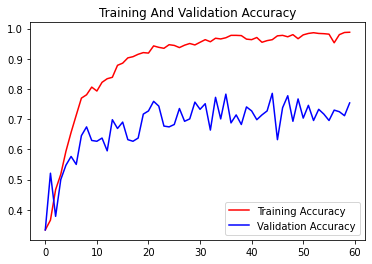

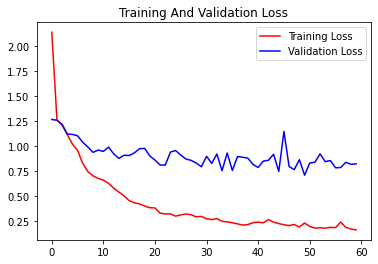

In [ ]:
acc_loss_plt(con_model8_history)

### Finding:
Getting worse.

## Convolutional Model 9

In [ ]:
con_model9 = keras.Sequential([
    keras.layers.Conv2D(128, (3,3), activation="relu", input_shape=(150,150,3), kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.3),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.3),
    keras.layers.MaxPooling2D(2,2),
      
    keras.layers.Conv2D(256, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D(2,2),
      
    keras.layers.Conv2D(256, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.2),   
    keras.layers.MaxPooling2D(2,2),    

    keras.layers.Conv2D(512, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.2),  
    keras.layers.MaxPooling2D(2,2),
       
    keras.layers.Flatten(),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(512, activation="relu", activity_regularizer=l2(l=0.001), kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(512, activation="relu", activity_regularizer=l2(l=0.001), kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dense(3, activation="softmax")
])

con_model9.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 148, 148, 128)     3584      
                                                                 
 dropout_50 (Dropout)        (None, 148, 148, 128)     0         
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 74, 74, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 72, 72, 128)       147584    
                                                                 
 dropout_51 (Dropout)        (None, 72, 72, 128)       0         
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 36, 36, 128)      0         
 g2D)                                                

In [ ]:
con_model9.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

con_model9_history = con_model9.fit(train_generator,
                                    validation_data=test_generator,
                                    validation_steps=3,
                                    epochs=50,
                                    steps_per_epoch=20,
                                    verbose=1)

Epoch 1/50
20/20 [==============================] - 18s 852ms/step - loss: 1.3204 - accuracy: 0.3528 - val_loss: 1.2855 - val_accuracy: 0.3466
Epoch 2/50
20/20 [==============================] - 17s 839ms/step - loss: 1.2777 - accuracy: 0.3639 - val_loss: 1.2726 - val_accuracy: 0.3228
Epoch 3/50
20/20 [==============================] - 17s 846ms/step - loss: 1.2574 - accuracy: 0.3563 - val_loss: 1.2453 - val_accuracy: 0.3439
Epoch 4/50
20/20 [==============================] - 17s 821ms/step - loss: 1.1460 - accuracy: 0.4689 - val_loss: 1.0022 - val_accuracy: 0.5847
Epoch 5/50
20/20 [==============================] - 17s 848ms/step - loss: 0.9286 - accuracy: 0.5940 - val_loss: 0.9343 - val_accuracy: 0.6085
Epoch 6/50
20/20 [==============================] - 17s 852ms/step - loss: 0.8172 - accuracy: 0.6659 - val_loss: 0.9206 - val_accuracy: 0.5926
Epoch 7/50
20/20 [==============================] - 17s 842ms/step - loss: 0.6811 - accuracy: 0.7655 - val_loss: 0.8988 - val_accuracy: 0.5952

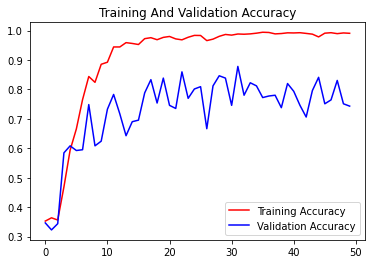

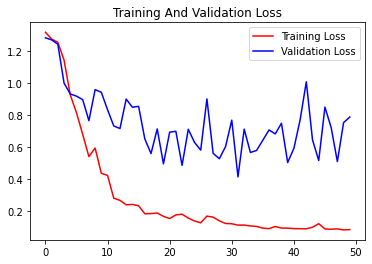

In [ ]:
acc_loss_plt(con_model9_history)

### Finding:
Not getting better.


## Convolutional Model 10

In [ ]:
con_model10 = keras.Sequential([
    keras.layers.Conv2D(64, (3,3), activation="relu", input_shape=(150,150,3), kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.3),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(64, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.3),
    keras.layers.MaxPooling2D(2,2),
      
    keras.layers.Conv2D(128, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D(2,2),
      
    keras.layers.Conv2D(128, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.2),   
    keras.layers.MaxPooling2D(2,2),    

    keras.layers.Conv2D(256, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.2),  
    keras.layers.MaxPooling2D(2,2),
       
    keras.layers.Flatten(),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(512, activation="relu", activity_regularizer=l2(l=0.001), kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(256, activation="relu", activity_regularizer=l2(l=0.001), kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dense(3, activation="softmax")
])

con_model10.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 dropout_57 (Dropout)        (None, 148, 148, 64)      0         
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 72, 72, 64)        36928     
                                                                 
 dropout_58 (Dropout)        (None, 72, 72, 64)        0         
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                

In [ ]:
con_model10.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

con_model10_history = con_model10.fit(train_generator,
                                    validation_data=test_generator,
                                    validation_steps=3,
                                    epochs=50,
                                    steps_per_epoch=20,
                                    verbose=1)

Epoch 1/50
20/20 [==============================] - 19s 846ms/step - loss: 1.2394 - accuracy: 0.3484 - val_loss: 1.2202 - val_accuracy: 0.5106
Epoch 2/50
20/20 [==============================] - 17s 855ms/step - loss: 1.1536 - accuracy: 0.4460 - val_loss: 1.2329 - val_accuracy: 0.3307
Epoch 3/50
20/20 [==============================] - 17s 831ms/step - loss: 1.0410 - accuracy: 0.5286 - val_loss: 1.0691 - val_accuracy: 0.5079
Epoch 4/50
20/20 [==============================] - 17s 858ms/step - loss: 0.9058 - accuracy: 0.5790 - val_loss: 1.1306 - val_accuracy: 0.4497
Epoch 5/50
20/20 [==============================] - 17s 848ms/step - loss: 0.8670 - accuracy: 0.6262 - val_loss: 1.1209 - val_accuracy: 0.4471
Epoch 6/50
20/20 [==============================] - 17s 855ms/step - loss: 0.7944 - accuracy: 0.6750 - val_loss: 0.9698 - val_accuracy: 0.5159
Epoch 7/50
20/20 [==============================] - 17s 819ms/step - loss: 0.7069 - accuracy: 0.7367 - val_loss: 0.9647 - val_accuracy: 0.5582

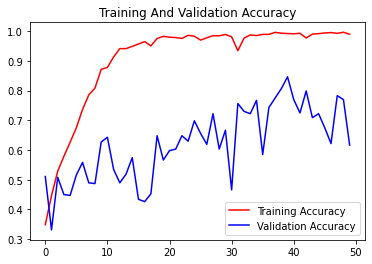

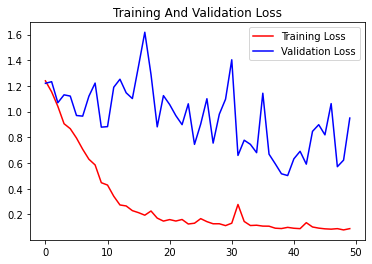

In [ ]:
acc_loss_plt(con_model10_history)

### Finding:
Not getting beter.

## Convolutional Model 11

In [ ]:
con_model11 = keras.Sequential([
    keras.layers.Conv2D(128, (3,3), activation="relu", input_shape=(150,150,3), kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(256, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D(2,2),
      
    keras.layers.Conv2D(512, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.2),  
    keras.layers.MaxPooling2D(2,2),
       
    keras.layers.Flatten(),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(512, activation="relu", activity_regularizer=l2(l=0.001), kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.8),
    keras.layers.Dense(256, activation="relu", activity_regularizer=l2(l=0.001), kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dense(3, activation="softmax")
])

con_model11.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_62 (Conv2D)          (None, 148, 148, 128)     3584      
                                                                 
 dropout_64 (Dropout)        (None, 148, 148, 128)     0         
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 74, 74, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_63 (Conv2D)          (None, 72, 72, 256)       295168    
                                                                 
 dropout_65 (Dropout)        (None, 72, 72, 256)       0         
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 36, 36, 256)      0         
 g2D)                                                

In [ ]:
con_model11.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

con_model11_history = con_model11.fit(train_generator,
                                    validation_data=test_generator,
                                    validation_steps=3,
                                    epochs=50,
                                    steps_per_epoch=30,
                                    verbose=1)

Epoch 1/50
30/30 [==============================] - 32s 846ms/step - loss: 1.8193 - accuracy: 0.3532 - val_loss: 1.3573 - val_accuracy: 0.3095
Epoch 2/50
30/30 [==============================] - 26s 845ms/step - loss: 1.2999 - accuracy: 0.4431 - val_loss: 1.1678 - val_accuracy: 0.6296
Epoch 3/50
30/30 [==============================] - 26s 852ms/step - loss: 1.0889 - accuracy: 0.6011 - val_loss: 1.0514 - val_accuracy: 0.6323
Epoch 4/50
30/30 [==============================] - 26s 846ms/step - loss: 0.8927 - accuracy: 0.7132 - val_loss: 1.0082 - val_accuracy: 0.6587
Epoch 5/50
30/30 [==============================] - 26s 851ms/step - loss: 0.7711 - accuracy: 0.7628 - val_loss: 1.0281 - val_accuracy: 0.6138
Epoch 6/50
30/30 [==============================] - 26s 837ms/step - loss: 0.7093 - accuracy: 0.8013 - val_loss: 1.2125 - val_accuracy: 0.6455
Epoch 7/50
30/30 [==============================] - 26s 856ms/step - loss: 0.5940 - accuracy: 0.8561 - val_loss: 1.2071 - val_accuracy: 0.5899

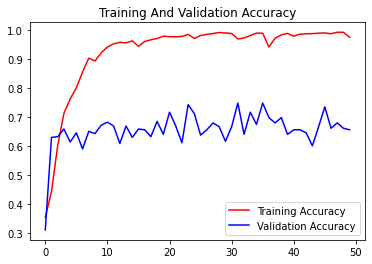

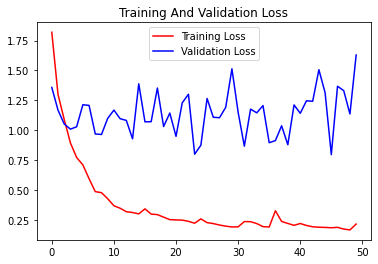

In [ ]:
acc_loss_plt(con_model11_history)

### Finding:
Getting worse.

## Convolutional Model 12

In [ ]:
con_model12 = keras.Sequential([
    keras.layers.Conv2D(64, (3,3), activation="relu", input_shape=(150,150,3), kernel_regularizer=l2(l=0.0001), padding="same"),
    keras.layers.Conv2D(64, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001), padding="same"),
    keras.layers.Dropout(0.3),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001), padding="same"),
    keras.layers.Conv2D(128, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001), padding="same"),
    keras.layers.Dropout(0.3),
    keras.layers.MaxPooling2D(2,2),
      
    keras.layers.Conv2D(256, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001), padding="same"),
    keras.layers.Conv2D(256, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001), padding="same"),
    keras.layers.Conv2D(256, (3,3), activation="relu", kernel_regularizer=l2(l=0.0001), padding="same"),
    keras.layers.Dropout(0.2),  
    keras.layers.MaxPooling2D(2,2),
       
    keras.layers.Flatten(),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(512, activation="relu", activity_regularizer=l2(l=0.001), kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(256, activation="relu", activity_regularizer=l2(l=0.001), kernel_regularizer=l2(l=0.0001)),
    keras.layers.Dense(3, activation="softmax")
])

con_model12.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 150, 150, 64)      1792      
                                                                 
 conv2d_66 (Conv2D)          (None, 150, 150, 64)      36928     
                                                                 
 dropout_69 (Dropout)        (None, 150, 150, 64)      0         
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 75, 75, 128)       73856     
                                                                 
 conv2d_68 (Conv2D)          (None, 75, 75, 128)       147584    
                                                     

In [ ]:
con_model12.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

con_model12_history = con_model12.fit(train_generator,
                                    validation_data=test_generator,
                                    validation_steps=10,
                                    epochs=40,
                                    steps_per_epoch=20,
                                    verbose=1)

Epoch 1/40
20/20 [==============================] - 30s 964ms/step - loss: 1.4423 - accuracy: 0.3448 - val_loss: 1.3457 - val_accuracy: 0.3310
Epoch 2/40
20/20 [==============================] - 19s 947ms/step - loss: 1.3331 - accuracy: 0.3393 - val_loss: 1.3148 - val_accuracy: 0.3262
Epoch 3/40
20/20 [==============================] - 21s 1s/step - loss: 1.2979 - accuracy: 0.3686 - val_loss: 1.2797 - val_accuracy: 0.3365
Epoch 4/40
20/20 [==============================] - 20s 963ms/step - loss: 1.2247 - accuracy: 0.4349 - val_loss: 1.1618 - val_accuracy: 0.4968
Epoch 5/40
20/20 [==============================] - 19s 942ms/step - loss: 1.2173 - accuracy: 0.4504 - val_loss: 1.2196 - val_accuracy: 0.4579
Epoch 6/40
20/20 [==============================] - 19s 931ms/step - loss: 1.1470 - accuracy: 0.4967 - val_loss: 1.1943 - val_accuracy: 0.4222
Epoch 7/40
20/20 [==============================] - 20s 952ms/step - loss: 1.0929 - accuracy: 0.5321 - val_loss: 1.1882 - val_accuracy: 0.4532
Ep

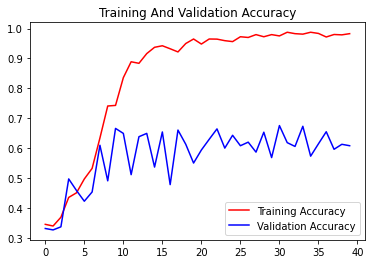

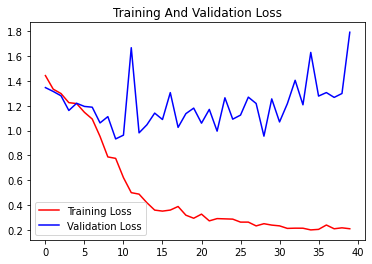

In [ ]:
acc_loss_plt(con_model12_history)

### Finding:
Getting worse. Get the best Model so far, Model 6 and ajust it from there.

## BEST MODEL: Convolutional Model 13 <a class="anchor" id="4.2"></a>


In [ ]:
con_model13 = keras.Sequential([
    keras.layers.Conv2D(128, (3,3), activation="relu", input_shape=(150,150,3), kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.3),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), activation="relu", kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.3),
    keras.layers.MaxPooling2D(2,2),
      
    keras.layers.Conv2D(256, (3,3), activation="relu", kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D(2,2),
      
    keras.layers.Conv2D(256, (3,3), activation="relu", kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.2),   
    keras.layers.MaxPooling2D(2,2),    

    keras.layers.Conv2D(512, (3,3), activation="relu", kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.2),  
    keras.layers.MaxPooling2D(2,2),
       
    keras.layers.Flatten(),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(512, activation="relu", activity_regularizer=l2(l=0.001), kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.8),
    keras.layers.Dense(256, activation="relu", activity_regularizer=l2(l=0.001), kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dense(3, activation="softmax")
])

con_model13.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_77 (Conv2D)          (None, 148, 148, 128)     3584      
                                                                 
 dropout_81 (Dropout)        (None, 148, 148, 128)     0         
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 74, 74, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_78 (Conv2D)          (None, 72, 72, 128)       147584    
                                                                 
 dropout_82 (Dropout)        (None, 72, 72, 128)       0         
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 36, 36, 128)      0         
 g2D)                                                

In [ ]:
con_model13.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

con_model13_history = con_model13.fit(train_generator,
                                    validation_data=test_generator,
                                    validation_steps=3,
                                    epochs=50,
                                    steps_per_epoch=30,
                                    verbose=1)

Epoch 1/50
30/30 [==============================] - 26s 820ms/step - loss: 1.1298 - accuracy: 0.3377 - val_loss: 1.1159 - val_accuracy: 0.3889
Epoch 2/50
30/30 [==============================] - 25s 816ms/step - loss: 1.0812 - accuracy: 0.4198 - val_loss: 1.0508 - val_accuracy: 0.5344
Epoch 3/50
30/30 [==============================] - 25s 816ms/step - loss: 0.9826 - accuracy: 0.5127 - val_loss: 1.0694 - val_accuracy: 0.4074
Epoch 4/50
30/30 [==============================] - 25s 811ms/step - loss: 0.7463 - accuracy: 0.6473 - val_loss: 1.0485 - val_accuracy: 0.4339
Epoch 5/50
30/30 [==============================] - 24s 795ms/step - loss: 0.6142 - accuracy: 0.7533 - val_loss: 0.8115 - val_accuracy: 0.5556
Epoch 6/50
30/30 [==============================] - 25s 815ms/step - loss: 0.4276 - accuracy: 0.8640 - val_loss: 0.7411 - val_accuracy: 0.6508
Epoch 7/50
30/30 [==============================] - 24s 802ms/step - loss: 0.3252 - accuracy: 0.8998 - val_loss: 0.8835 - val_accuracy: 0.5714

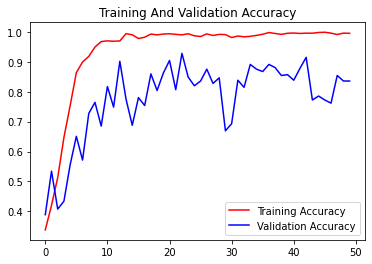

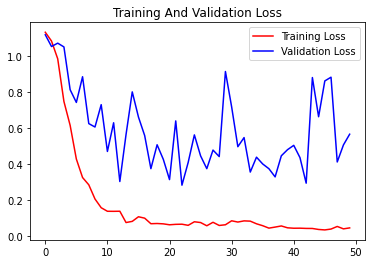

In [ ]:
acc_loss_plt(con_model13_history)

### Finding:
Finally getting better!!

## Convolutional Model 14

In [ ]:
con_model14 = keras.Sequential([
    keras.layers.Conv2D(128, (3,3), activation="relu", input_shape=(150,150,3), kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), activation="relu", kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D(2,2),
      
    keras.layers.Conv2D(256, (3,3), activation="relu", kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.3),
    keras.layers.MaxPooling2D(2,2),
      
    keras.layers.Conv2D(512, (3,3), activation="relu", kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.3),   
    keras.layers.MaxPooling2D(2,2),    

    keras.layers.Conv2D(512, (3,3), activation="relu", kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.3),  
    keras.layers.MaxPooling2D(2,2),
       
    keras.layers.Flatten(),
    keras.layers.Dropout(0.8),
    keras.layers.Dense(512, activation="relu", activity_regularizer=l2(l=0.001), kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.8),
    keras.layers.Dense(256, activation="relu", activity_regularizer=l2(l=0.001), kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dense(3, activation="softmax")
])

con_model14.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_92 (Conv2D)          (None, 148, 148, 128)     3584      
                                                                 
 dropout_102 (Dropout)       (None, 148, 148, 128)     0         
                                                                 
 max_pooling2d_83 (MaxPoolin  (None, 74, 74, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_93 (Conv2D)          (None, 72, 72, 128)       147584    
                                                                 
 dropout_103 (Dropout)       (None, 72, 72, 128)       0         
                                                                 
 max_pooling2d_84 (MaxPoolin  (None, 36, 36, 128)      0         
 g2D)                                                

In [ ]:
con_model14.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

con_model14_history = con_model14.fit(train_generator,
                                    validation_data=test_generator,
                                    validation_steps=3,
                                    epochs=50,
                                    steps_per_epoch=20,
                                    verbose=1)

Epoch 1/50
20/20 [==============================] - 19s 881ms/step - loss: 1.1543 - accuracy: 0.3421 - val_loss: 1.1223 - val_accuracy: 0.3122
Epoch 2/50
20/20 [==============================] - 17s 829ms/step - loss: 1.0859 - accuracy: 0.3976 - val_loss: 1.0859 - val_accuracy: 0.4894
Epoch 3/50
20/20 [==============================] - 17s 811ms/step - loss: 1.1112 - accuracy: 0.3682 - val_loss: 1.1209 - val_accuracy: 0.3519
Epoch 4/50
20/20 [==============================] - 17s 839ms/step - loss: 1.0444 - accuracy: 0.4802 - val_loss: 1.0333 - val_accuracy: 0.5344
Epoch 5/50
20/20 [==============================] - 17s 839ms/step - loss: 0.9556 - accuracy: 0.5643 - val_loss: 1.1339 - val_accuracy: 0.3280
Epoch 6/50
20/20 [==============================] - 17s 810ms/step - loss: 0.8779 - accuracy: 0.5987 - val_loss: 1.0663 - val_accuracy: 0.3968
Epoch 7/50
20/20 [==============================] - 17s 839ms/step - loss: 0.7458 - accuracy: 0.6575 - val_loss: 1.1535 - val_accuracy: 0.4127

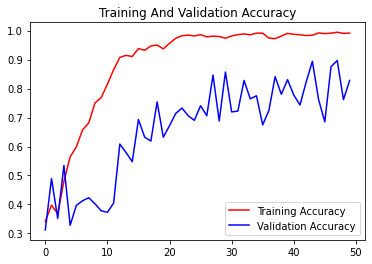

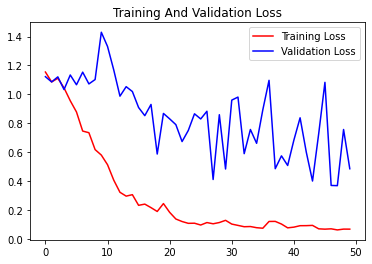

In [ ]:
acc_loss_plt(con_model14_history)

### Finding:
Can't say it's getting better. In fact, the val_accuracy is getting worse.

From model 13, chnage one 128 layer to 256. 

## Convolutional Model 15

In [ ]:
con_model15_1 = keras.Sequential([
    keras.layers.Conv2D(128, (3,3), activation="relu", input_shape=(150,150,3), kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.8),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), activation="relu", kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.6),
    keras.layers.MaxPooling2D(2,2),
      
    keras.layers.Conv2D(256, (3,3), activation="relu", kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D(2,2),
      
    keras.layers.Conv2D(256, (3,3), activation="relu", kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.2),   
    keras.layers.MaxPooling2D(2,2),    

    keras.layers.Conv2D(512, (3,3), activation="relu", kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.2),  
    keras.layers.MaxPooling2D(2,2),
       
    keras.layers.Flatten(),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(512, activation="relu", activity_regularizer=l2(l=0.001), kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.8),
    keras.layers.Dense(256, activation="relu", activity_regularizer=l2(l=0.001), kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dense(3, activation="softmax")
])

con_model15_1.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_102 (Conv2D)         (None, 148, 148, 128)     3584      
                                                                 
 dropout_116 (Dropout)       (None, 148, 148, 128)     0         
                                                                 
 max_pooling2d_93 (MaxPoolin  (None, 74, 74, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_103 (Conv2D)         (None, 72, 72, 128)       147584    
                                                                 
 dropout_117 (Dropout)       (None, 72, 72, 128)       0         
                                                                 
 max_pooling2d_94 (MaxPoolin  (None, 36, 36, 128)      0         
 g2D)                                                

In [ ]:
con_model15_1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

con_model15_1_history = con_model15_1.fit(train_generator,
                                    validation_data=test_generator,
                                    validation_steps=3,
                                    epochs=60,
                                    steps_per_epoch=30,
                                    verbose=1)

Epoch 1/60
30/30 [==============================] - 27s 858ms/step - loss: 1.2184 - accuracy: 0.3294 - val_loss: 1.1192 - val_accuracy: 0.3492
Epoch 2/60
30/30 [==============================] - 25s 827ms/step - loss: 1.1196 - accuracy: 0.3527 - val_loss: 1.1190 - val_accuracy: 0.3413
Epoch 3/60
30/30 [==============================] - 25s 828ms/step - loss: 1.1179 - accuracy: 0.3510 - val_loss: 1.1178 - val_accuracy: 0.3545
Epoch 4/60
30/30 [==============================] - 26s 843ms/step - loss: 1.0819 - accuracy: 0.4019 - val_loss: 1.1196 - val_accuracy: 0.3201
Epoch 5/60
30/30 [==============================] - 24s 804ms/step - loss: 0.9912 - accuracy: 0.4877 - val_loss: 1.1921 - val_accuracy: 0.3439
Epoch 6/60
30/30 [==============================] - 25s 830ms/step - loss: 0.8519 - accuracy: 0.6074 - val_loss: 1.4394 - val_accuracy: 0.3360
Epoch 7/60
30/30 [==============================] - 24s 804ms/step - loss: 0.7000 - accuracy: 0.7130 - val_loss: 1.4450 - val_accuracy: 0.3545

KeyboardInterrupt: ignored

In [ ]:
# acc_loss_plt(con_model15_history)

### Finding:
The val_acc is not improving at all.  This is a bad leyer set up.  Interrupt the cell.  No need to keep runrunning.



## Convolutional Model 16

In [ ]:
con_model16 = keras.Sequential([
    keras.layers.Conv2D(128, (3,3), activation="relu", input_shape=(150,150,3), kernel_regularizer=l2(l=0.00001)),
  keras.layers.Conv2D(128, (3,3), activation="relu", kernel_regularizer=l2(l=0.00001)),   # new layer
    keras.layers.Dropout(0.5),    # Change 0.3 to 0.5
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), activation="relu", kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.3),
    keras.layers.MaxPooling2D(2,2),
      
    keras.layers.Conv2D(256, (3,3), activation="relu", kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D(2,2),
      
    keras.layers.Conv2D(256, (3,3), activation="relu", kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.2),   
    keras.layers.MaxPooling2D(2,2),    

    keras.layers.Conv2D(512, (3,3), activation="relu", kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.2),  
    keras.layers.MaxPooling2D(2,2),
       
    keras.layers.Flatten(),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(512, activation="relu", activity_regularizer=l2(l=0.001), kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.8),
    keras.layers.Dense(256, activation="relu", activity_regularizer=l2(l=0.001), kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dense(3, activation="softmax")
])

con_model16.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_107 (Conv2D)         (None, 148, 148, 128)     3584      
                                                                 
 conv2d_108 (Conv2D)         (None, 146, 146, 128)     147584    
                                                                 
 dropout_123 (Dropout)       (None, 146, 146, 128)     0         
                                                                 
 max_pooling2d_98 (MaxPoolin  (None, 73, 73, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_109 (Conv2D)         (None, 71, 71, 128)       147584    
                                                                 
 dropout_124 (Dropout)       (None, 71, 71, 128)       0         
                                                     

In [ ]:
con_model16.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

con_model16_history = con_model16.fit(train_generator,
                                    validation_data=test_generator,
                                    validation_steps=3,
                                    epochs=50,
                                    steps_per_epoch=20,
                                    verbose=1)

Epoch 1/50
20/20 [==============================] - 26s 901ms/step - loss: 1.1289 - accuracy: 0.3425 - val_loss: 1.1178 - val_accuracy: 0.3571
Epoch 2/50
20/20 [==============================] - 18s 870ms/step - loss: 1.0923 - accuracy: 0.4048 - val_loss: 1.1197 - val_accuracy: 0.3333
Epoch 3/50
20/20 [==============================] - 19s 912ms/step - loss: 1.0299 - accuracy: 0.4747 - val_loss: 1.1486 - val_accuracy: 0.2804
Epoch 4/50
20/20 [==============================] - 18s 878ms/step - loss: 0.9872 - accuracy: 0.5246 - val_loss: 1.1666 - val_accuracy: 0.3413
Epoch 5/50
20/20 [==============================] - 18s 879ms/step - loss: 0.8102 - accuracy: 0.6583 - val_loss: 1.5399 - val_accuracy: 0.3360
Epoch 6/50
20/20 [==============================] - 18s 888ms/step - loss: 0.6786 - accuracy: 0.7274 - val_loss: 1.2449 - val_accuracy: 0.4074
Epoch 7/50
20/20 [==============================] - 18s 882ms/step - loss: 0.6144 - accuracy: 0.7631 - val_loss: 1.6062 - val_accuracy: 0.3333

KeyboardInterrupt: ignored

In [1]:
# acc_loss_plt(con_model16_history)

### Finding:
Interrupt the cell since it's not imporving.

## Convolutional Model 17

In [ ]:
con_model17 = keras.Sequential([
    keras.layers.Conv2D(128, (3,3), activation="relu", input_shape=(150,150,3), kernel_regularizer=l2(l=0.000005)),
    keras.layers.BatchNormalization(),    # New layer: BatchNormalization   
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), activation="relu", kernel_regularizer=l2(l=0.000005)),
    keras.layers.Dropout(0.3),
    keras.layers.MaxPooling2D(2,2),
      
    keras.layers.Conv2D(256, (3,3), activation="relu", kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D(2,2),
      
    keras.layers.Conv2D(256, (3,3), activation="relu", kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.2),   
    keras.layers.MaxPooling2D(2,2),    

    keras.layers.Conv2D(512, (3,3), activation="relu", kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.2),  
    keras.layers.MaxPooling2D(2,2),
       
    keras.layers.Flatten(),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(512, activation="relu", activity_regularizer=l2(l=0.001), kernel_regularizer=l2(l=000001.)),
    keras.layers.Dropout(0.8),
    keras.layers.Dense(256, activation="relu", activity_regularizer=l2(l=0.001), kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dense(3, activation="softmax")
])

con_model17.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_113 (Conv2D)         (None, 148, 148, 128)     3584      
                                                                 
 batch_normalization_3 (Batc  (None, 148, 148, 128)    512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_103 (MaxPooli  (None, 74, 74, 128)      0         
 ng2D)                                                           
                                                                 
 conv2d_114 (Conv2D)         (None, 72, 72, 128)       147584    
                                                                 
 dropout_130 (Dropout)       (None, 72, 72, 128)       0         
                                                                 
 max_pooling2d_104 (MaxPooli  (None, 36, 36, 128)    

In [ ]:
con_model17.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

con_model17_history = con_model17.fit(train_generator,
                                    validation_data=test_generator,
                                    validation_steps=3,
                                    epochs=50,
                                    steps_per_epoch=20,
                                    verbose=1)

Epoch 1/50
20/20 [==============================] - 18s 835ms/step - loss: 457.3049 - accuracy: 0.3437 - val_loss: 184.9027 - val_accuracy: 0.3413
Epoch 2/50
20/20 [==============================] - 17s 830ms/step - loss: 86.2808 - accuracy: 0.3278 - val_loss: 23.7029 - val_accuracy: 0.3677
Epoch 3/50
20/20 [==============================] - 17s 852ms/step - loss: 9.5994 - accuracy: 0.3337 - val_loss: 2.4997 - val_accuracy: 0.3413
Epoch 4/50
20/20 [==============================] - 17s 849ms/step - loss: 1.6514 - accuracy: 0.3679 - val_loss: 1.3021 - val_accuracy: 0.3439
Epoch 5/50
20/20 [==============================] - 17s 843ms/step - loss: 1.2518 - accuracy: 0.3845 - val_loss: 1.2062 - val_accuracy: 0.3413
Epoch 6/50
20/20 [==============================] - 17s 833ms/step - loss: 1.2374 - accuracy: 0.4460 - val_loss: 1.2437 - val_accuracy: 0.4841
Epoch 7/50
20/20 [==============================] - 17s 837ms/step - loss: 1.2095 - accuracy: 0.5063 - val_loss: 1.3224 - val_accuracy: 

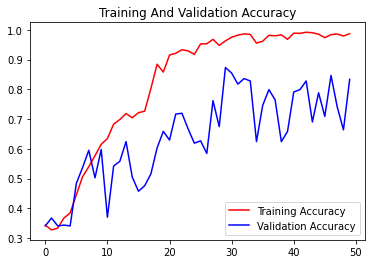

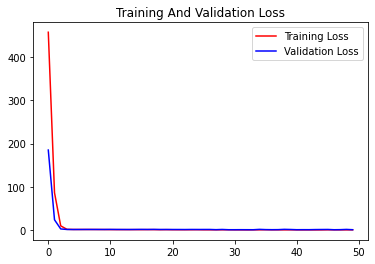

In [ ]:
acc_loss_plt(con_model17_history)

### Finding:
Changing dataset. shear_rate = 0.2. 

## Convolutioinal Model 18

In [ ]:
con_model18 = keras.Sequential([
    keras.layers.Conv2D(128, (3,3), activation="relu", input_shape=(150,150,3), kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.3),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), activation="relu", kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.3),
    keras.layers.MaxPooling2D(2,2),
      
    keras.layers.Conv2D(256, (3,3), activation="relu", kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D(2,2),
      
    keras.layers.Conv2D(256, (3,3), activation="relu", kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.2),   
    keras.layers.MaxPooling2D(2,2),    

    keras.layers.Conv2D(512, (3,3), activation="relu", kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.2),  
    keras.layers.MaxPooling2D(2,2),
       
    keras.layers.Flatten(),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(512, activation="relu", activity_regularizer=l2(l=0.001), kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.8),
    keras.layers.Dense(256, activation="relu", activity_regularizer=l2(l=0.001), kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dense(3, activation="softmax")
])


con_model18.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_123 (Conv2D)         (None, 148, 148, 128)     3584      
                                                                 
 dropout_143 (Dropout)       (None, 148, 148, 128)     0         
                                                                 
 max_pooling2d_113 (MaxPooli  (None, 74, 74, 128)      0         
 ng2D)                                                           
                                                                 
 conv2d_124 (Conv2D)         (None, 72, 72, 128)       147584    
                                                                 
 dropout_144 (Dropout)       (None, 72, 72, 128)       0         
                                                                 
 max_pooling2d_114 (MaxPooli  (None, 36, 36, 128)      0         
 ng2D)                                               

In [ ]:
con_model18.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

con_model18_history = con_model18.fit(train_generator,
                                    validation_data=test_generator,
                                    validation_steps=3,
                                    epochs=50,
                                    steps_per_epoch=30,
                                    verbose=1)

Epoch 1/50
30/30 [==============================] - 27s 829ms/step - loss: 1.1334 - accuracy: 0.3399 - val_loss: 1.1179 - val_accuracy: 0.3360
Epoch 2/50
30/30 [==============================] - 25s 818ms/step - loss: 1.0933 - accuracy: 0.3902 - val_loss: 1.0978 - val_accuracy: 0.4471
Epoch 3/50
30/30 [==============================] - 25s 812ms/step - loss: 1.0154 - accuracy: 0.4923 - val_loss: 1.2328 - val_accuracy: 0.3201
Epoch 4/50
30/30 [==============================] - 24s 804ms/step - loss: 1.0452 - accuracy: 0.4624 - val_loss: 1.0863 - val_accuracy: 0.4127
Epoch 5/50
30/30 [==============================] - 25s 824ms/step - loss: 0.9272 - accuracy: 0.5728 - val_loss: 0.9104 - val_accuracy: 0.4921
Epoch 6/50
30/30 [==============================] - 25s 810ms/step - loss: 0.7557 - accuracy: 0.6585 - val_loss: 1.1007 - val_accuracy: 0.5026
Epoch 7/50
30/30 [==============================] - 25s 818ms/step - loss: 0.6668 - accuracy: 0.7196 - val_loss: 1.1335 - val_accuracy: 0.5053

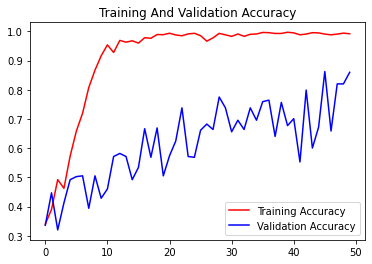

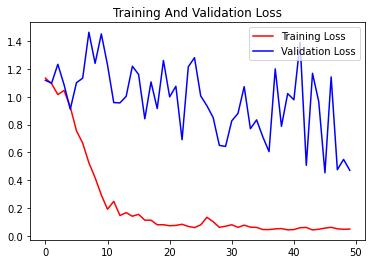

In [ ]:
acc_loss_plt(con_model18_history)

### Finding:
Not getting better.

## Convolutioinal Model 19

In [ ]:
con_model19 = keras.Sequential([
    keras.layers.Conv2D(128, (3,3), activation="relu", input_shape=(150,150,3), kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.6),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), activation="relu", kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.5),
    keras.layers.MaxPooling2D(2,2),
      
    keras.layers.Conv2D(256, (3,3), activation="relu", kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D(2,2),
      
    keras.layers.Conv2D(256, (3,3), activation="relu", kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.2),   
    keras.layers.MaxPooling2D(2,2),    

    keras.layers.Conv2D(512, (3,3), activation="relu", kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.2),  
    keras.layers.MaxPooling2D(2,2),
       
    keras.layers.Flatten(),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(512, activation="relu", activity_regularizer=l2(l=0.001), kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dropout(0.8),
    keras.layers.Dense(256, activation="relu", activity_regularizer=l2(l=0.001), kernel_regularizer=l2(l=0.00001)),
    keras.layers.Dense(3, activation="softmax")
])


con_model19.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_128 (Conv2D)         (None, 148, 148, 128)     3584      
                                                                 
 dropout_150 (Dropout)       (None, 148, 148, 128)     0         
                                                                 
 max_pooling2d_118 (MaxPooli  (None, 74, 74, 128)      0         
 ng2D)                                                           
                                                                 
 conv2d_129 (Conv2D)         (None, 72, 72, 128)       147584    
                                                                 
 dropout_151 (Dropout)       (None, 72, 72, 128)       0         
                                                                 
 max_pooling2d_119 (MaxPooli  (None, 36, 36, 128)      0         
 ng2D)                                               

In [ ]:
con_model19.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

con_model19_history = con_model19.fit(train_generator,
                                    validation_data=test_generator,
                                    validation_steps=3,
                                    epochs=60,
                                    steps_per_epoch=30,
                                    verbose=1)

Epoch 1/60
30/30 [==============================] - 26s 833ms/step - loss: 1.1745 - accuracy: 0.3352 - val_loss: 1.1188 - val_accuracy: 0.3651
Epoch 2/60
30/30 [==============================] - 25s 809ms/step - loss: 1.1156 - accuracy: 0.3481 - val_loss: 1.1146 - val_accuracy: 0.3942
Epoch 3/60
30/30 [==============================] - 25s 809ms/step - loss: 1.0231 - accuracy: 0.4804 - val_loss: 1.1084 - val_accuracy: 0.3254
Epoch 4/60
30/30 [==============================] - 25s 819ms/step - loss: 0.8802 - accuracy: 0.5886 - val_loss: 1.0116 - val_accuracy: 0.4286
Epoch 5/60
30/30 [==============================] - 25s 812ms/step - loss: 0.7222 - accuracy: 0.6958 - val_loss: 1.0028 - val_accuracy: 0.4577
Epoch 6/60
30/30 [==============================] - 25s 814ms/step - loss: 0.5545 - accuracy: 0.7955 - val_loss: 0.9854 - val_accuracy: 0.5026
Epoch 7/60
30/30 [==============================] - 25s 814ms/step - loss: 0.4468 - accuracy: 0.8540 - val_loss: 1.1264 - val_accuracy: 0.3889

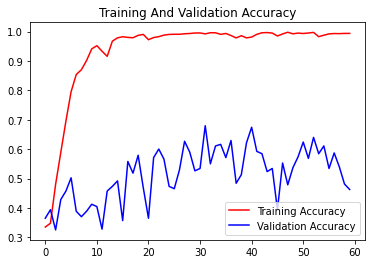

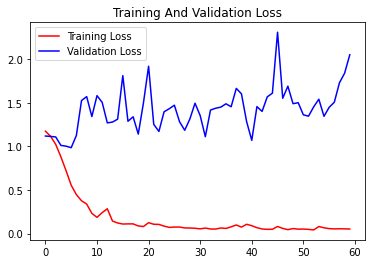

In [ ]:
acc_loss_plt(con_model19_history)

### Finding:
Getting worse!

## Save the best model!! <a class="anchor" id="4.3"></a>

Save the model for later use.

In [ ]:
Best_model = con_model13

In [ ]:
Best_model.save("./OtherNotebook_and_Files/Saved_model.h5")

## Web App Dployment Using Gradio<a class="anchor" id="5"></a>

In [ ]:
!pip install gradio

In [ ]:
from gradio import gr

In [ ]:
def webcam(inp):

  image_i = cv2.bitwise_not(inp)    #invert color
  
  cap_img = image_i.reshape((-1, 150, 150, 3))

  prediction = model.predict(cap_img, batch_size=10)

  for i in prediction:
    if i[0] == 1:
      label = "Paper"
    elif i[1] == 1:
      label = "Rock"
    else:
      label = "Scissors"
  
  # Being in Rock-Scissors-Paper game
  choices = ['Rock', 'Paper', 'Scissors']
  user_move = label
  computer_move = random.choice(choices)
  guess_dict = {'Rock': 0, 'Paper': 1, 'Scissors':2}
  guess_idx = guess_dict.get(user_move, 3)
  computer_idx = guess_dict.get(computer_move)
  result_matrix = [[0,2,1], [1,0,2], [2,1,0]]
  result_idx = result_matrix[guess_idx][computer_idx]
  result_messages = ['It is a tie', 'You win!!! Congrats!', 'Sorry, you lose :(']
  result = result_messages[result_idx]
  output_text = f"The model recognizes your move is {user_move}.\nComputer's move is {computer_move}.\n{result}"
  
  if computer_move == 'Rock':
    img_path = '/content/gdrive/MyDrive/rock_paper_scissors/MVP/computer_move_images/ROCK.png'
    computer_move_img = utils.load_img(img_path, target_size=(600, 600))
  elif computer_move == 'Paper':
    img_path = '/content/gdrive/MyDrive/rock_paper_scissors/MVP/computer_move_images/PAPER.png'
    computer_move_img = utils.load_img(img_path, target_size=(600, 600))
  else:
    img_path = '/content/gdrive/MyDrive/rock_paper_scissors/MVP/computer_move_images/SCISSORS.png'
    computer_move_img = utils.load_img(img_path, target_size=(600, 600))

  return computer_move_img, output_text, image_i

output1 = gr.Image(shape=(360,600), label="Computer's Move").style(height=360, width=600)
output2 = gr.Textbox(label='Game result')
output3 = gr.Image(shape=(360,600), label="This is what cumputer sees").style(height=360, width=600)

interface = gr.Interface(fn=webcam, 
             inputs=gr.Image(shape=(150, 150),
                             source='webcam',
                             streaming=True,
                             mirror_webcam=True,
                             invert_colors=False,
                             image_mode='RGB',
                             label='Please make your move CLOSE and CLEAR!!'),
             outputs=[output1, output2, output3],
             title="Rock-Scissors-Paper Image Game with Computer",
             live=False)

interface.launch(debug=True, share=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://780576f9-09d9-4ba2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


1/1 [==============================] - 0s 21ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://780576f9-09d9-4ba2.gradio.live
